In this python file we compute the cost for a network under a Wardrop Equilibrium.
If you don't know what that is, two good places to start:
- Pau's slides on this, slide 9 ish https://classroom.google.com/c/NDkyMDU5MTg0Mjg1/m/NTk4MTEzNTU4NzM3/details
- check out the methodology section of the Networks II paper here:
    https://classroom.google.com/c/NDkyMDU5MTg0Mjg1/p/NTQzNjcyNDMwMTkx?pli=1



I use the code from [this notebook](https://nbviewer.org/github/PyTrans/Urban-Network-Analysis/blob/master/Trip_Assignment-Frank-Wolfe_Algorithm.ipynb) to solve the Wardrop Equilibrium  for a multi-source/sink traffic flow problem.

you may need to download the pytrans github repository before running this code. you can do this by running the following, according to the readme for the respository:
```
git clone https://github.com/PyTrans/Urban-Network-Analysis.git
```


# Computing the latency costs at equilbrium using pytrans

First, we import required packages.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from itertools import combinations
from bike_functions import *
import matplotlib.pyplot as plt
from pytrans.UrbanNetworkAnalysis import TransportationNetworks as tn

Files

In [3]:
link_file = 'Data/SiouxFalls_net.tntp'
trip_file = 'Data/SiouxFalls_trips.tntp'
node_file = 'Data/SiouxFalls_node.tntp'

SO = False # True - System optimum, False - User equilibrium
siouxFalls = tn.Network(link_file, trip_file, node_file)

# Social Equilibrium - no stations
### Implement iterative optimization steps (UE)
#### 1. Initialization

Perform the All-or-Nothing (AoN) assignment based on the free flow travel time (t0) and calculate the link performance (t1) based on the link volume (x0) 

In [5]:
## initialization

# define output variables, network and fwResult
network = {(u,v): {'t0':d['object'].t0, 'alpha':d['object'].alpha, \
           'beta':d['object'].beta, 'capa':d['object'].capacity, 'flow':[], \
           'auxiliary':[], 'cost':[]} for (u, v, d) in siouxFalls.graph.edges(data=True)}

fwResult = {'theta':[], 'z':[]}

# initial all-or-nothing assignment and update link travel time(cost)
siouxFalls.all_or_nothing_assignment()
siouxFalls.update_linkcost()

for linkKey, linkVal in network.items():
    linkVal['cost'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['weight'])
    linkVal['auxiliary'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].vol)
    linkVal['flow'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].vol)

5. Convergence Test 

Converge to the equilibrium.

In [6]:
## iterations
iterNum=0
iteration = True
while iteration:
    iterNum += 1
    siouxFalls.all_or_nothing_assignment()
    siouxFalls.update_linkcost()
    
    # set auxiliary flow using updated link flow
    for linkKey, linkVal in network.items():
        linkVal['auxiliary'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].vol)
        
    # getting optimal move size (theta)
    theta = lineSearch(network, SO)
    fwResult['theta'].append(theta)
    
    # set link flow (move) based on the theta, auxiliary flow, and link flow of previous iteration
    for linkKey, linkVal in network.items():
        aux = linkVal['auxiliary'][-1]
        flow = linkVal['flow'][-1]
        linkVal['flow'].append(flow + theta*(aux-flow))
        
        siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].vol =  flow + theta * (aux - flow)
        siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].flow = flow + theta * (aux - flow)
        
    # update link travel time
    siouxFalls.update_linkcost()
    
    # calculate objective function value
    z=0
    for linkKey, linkVal in network.items():
        linkVal['cost'].append(siouxFalls.graph[linkKey[0]][linkKey[1]]['weight'])
        totalcost = siouxFalls.graph[linkKey[0]][linkKey[1]]['object'].get_objective_function()
        z+=totalcost
        
    fwResult['z'].append(z)        
        
    # convergence test
    if iterNum == 1:
        iteration = True
    else:
        if abs(fwResult['z'][-2] - fwResult['z'][-1]) <= 0.001 or iterNum==3000:
            iteration = False

print('the cost from the last iteration, the equilibrium cost:', fwResult['z'][-1])

the cost from the last iteration, the equilibrium cost: 4231493.702767667


### Results
#### 1.Link Flow
Display the flows for each edge at social equilibrium

In [7]:
for (u, v, d) in siouxFalls.graph.edges(data=True):
    print(u, ' -> ', v, ': ', d['object'].vol)

1  ->  2 :  4494.541769852098
1  ->  3 :  8118.778958173066
2  ->  1 :  4519.221797815283
2  ->  6 :  5967.415424119265
3  ->  1 :  8094.098930209869
3  ->  4 :  14011.734532471419
3  ->  12 :  10027.635980459709
6  ->  2 :  5992.095452082454
6  ->  5 :  8806.41089044818
6  ->  8 :  12492.075339039784
4  ->  3 :  14035.300255070433
4  ->  5 :  18010.561177776
4  ->  11 :  5203.138655249939
12  ->  3 :  9979.390229897474
12  ->  11 :  8404.30673586717
12  ->  13 :  12293.49958224446
5  ->  4 :  18034.525517855654
5  ->  6 :  8797.189587004616
5  ->  9 :  15783.996289215766
11  ->  4 :  5302.740037769327
11  ->  10 :  17603.65214582616
11  ->  12 :  8365.259304389087
11  ->  14 :  9776.846543222036
9  ->  5 :  15798.739325851839
9  ->  8 :  6837.003588057352
9  ->  10 :  21745.98823501208
8  ->  6 :  12525.976670446556
8  ->  7 :  12041.696631400406
8  ->  9 :  6881.8139172902975
8  ->  16 :  8387.782258644345
7  ->  8 :  12102.268632503978
7  ->  18 :  15797.41185102116
18  ->  7 :  158

# Social Equilibrium: 1 Random station

In [3]:
siouxFalls2 = siouxFalls
station = pd.Series(filter_stations(list(combinations(np.array(siouxFalls2.graph.nodes),2)))).sample(1).values[0]
all_costs = []

# if len(g_copy.get_all_shortest_paths(station[0], station[1], weights='free_flow_time')) == 0:
#     exit()
# print('station 1: ', station[0], 'station 2:', station[1])

# get the shortest path between two nodes
shortest_path = nx.shortest_path(siouxFalls2.graph, station[0],station[1], weight='time')

# Calculate time, length and capacity
bike_edge_time = calculate_path_free_flow_time(shortest_path, siouxFalls2.graph) * 1/2
path_length = calculate_path_length(shortest_path, siouxFalls2.graph)
capacity = calculate_path_capacity(shortest_path, siouxFalls2.graph, path_length)


# If not an edge yet then add one:    
siouxFalls2.graph = add_or_modify_undirected_edge(siouxFalls2.graph, station[0], station[1], bike_edge_time, path_length, capacity)

node_colors = ['red' if node in station else 'blue' for node in siouxFalls2.graph.nodes()]

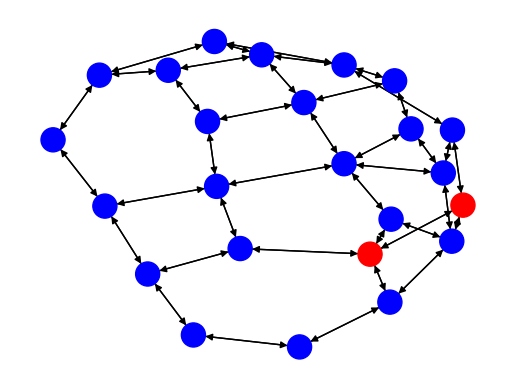

What happens if we add a path from 5 to 7, where the previous shortest path was ['5', '6', '8', '7']?


In [4]:
node_colors = ['red' if node in station else 'blue' for node in siouxFalls2.graph.nodes()]

fig, ax = plt.subplots()

pos = nx.spring_layout(siouxFalls2.graph)
nx.draw_networkx_nodes(siouxFalls2.graph, pos, node_color=node_colors)
nx.draw_networkx_edges(siouxFalls2.graph, pos, edgelist=siouxFalls2.graph.edges())
plt.axis('off')

plt.show()
print('What happens if we add a path from {} to {}, where the previous shortest path was {}?'.format(station[0], station[1], shortest_path))

In [5]:
# initialization

# define output variables, network and fwResult
network = {(u,v): {'t0':d['object'].t0, 'alpha':d['object'].alpha, \
           'beta':d['object'].beta, 'capa':d['object'].capacity, 'flow':[], \
           'auxiliary':[], 'cost':[]} for (u, v, d) in siouxFalls2.graph.edges(data=True)}

fwResult = {'theta':[], 'z':[]}

# initial all-or-nothing assignment and update link travel time(cost)
siouxFalls2.all_1r_nothing_assignment()
siouxFalls2.update_linkcost()

for linkKey, linkVal in network.items():
    linkVal['cost'].append(siouxFalls2.graph[linkKey[0]][linkKey[1]]['weight'])
    linkVal['auxiliary'].append(siouxFalls2.graph[linkKey[0]][linkKey[1]]['object'].vol)
    linkVal['flow'].append(siouxFalls2.graph[linkKey[0]][linkKey[1]]['object'].vol)

In [6]:
## iterations
iterNum = 0
iteration = True
while iteration:
    iterNum += 1
    siouxFalls2.all_1r_nothing_assignment()
    siouxFalls2.update_linkcost()
    
    # set auxiliary flow using updated link flow
    for linkKey, linkVal in network.items():
        linkVal['auxiliary'].append(siouxFalls2.graph[linkKey[0]][linkKey[1]]['object'].vol)
        
    # getting optimal move size (theta)
    theta = lineSearch(network, SO)
    fwResult['theta'].append(theta)
    
    # set link flow (move) based on the theta, auxiliary flow, and link flow of previous iteration
    for linkKey, linkVal in network.items():
        aux = linkVal['auxiliary'][-1]
        flow = linkVal['flow'][-1]
        linkVal['flow'].append(flow + theta*(aux-flow))
        
        siouxFalls2.graph[linkKey[0]][linkKey[1]]['object'].vol =  flow + theta * (aux - flow)
        siouxFalls2.graph[linkKey[0]][linkKey[1]]['object'].flow = flow + theta * (aux - flow)
        
    # update link travel time
    siouxFalls2.update_linkcost()
    
    # calculate objective function value
    z=0
    for linkKey, linkVal in network.items():
        linkVal['cost'].append(siouxFalls2.graph[linkKey[0]][linkKey[1]]['weight'])
        totalcost = siouxFalls2.graph[linkKey[0]][linkKey[1]]['object'].get_1bjective_function()
        z += totalcost
        
    fwResult['z'].append(z)        
        
    # convergence test
    if iterNum == 1:
        iteration = True
    else:
        if abs(fwResult['z'][-2] - fwResult['z'][-1]) <= 0.001 or iterNum==3000:
            iteration = False

In [7]:
print('the cost from the last iteration, the equilibrium cost:', fwResult['z'][-1])

the cost from the last iteration, the equilibrium cost: 3837733.645039034


In [8]:
for (u, v, d) in siouxFalls2.graph.edges(data=True):
    print(u, ' -> ', v, ': ', d['object'].vol)

1  ->  2 :  2803.5526555695724
1  ->  3 :  7995.96664765392
2  ->  1 :  2835.3048231535818
2  ->  6 :  4604.075926886986
3  ->  1 :  7964.214480069909
3  ->  4 :  17660.61174826328
3  ->  12 :  11618.412619773035
6  ->  2 :  4635.828094471004
6  ->  5 :  7074.435555897129
6  ->  8 :  9462.508654274014
4  ->  3 :  17649.8984460409
4  ->  5 :  23362.387553470435
4  ->  11 :  6601.36537368627
12  ->  3 :  11597.373754411467
12  ->  11 :  8216.714208039064
12  ->  13 :  12831.789475219883
5  ->  4 :  23451.52315826434
5  ->  6 :  7071.511603589964
5  ->  9 :  12459.28884063951
5  ->  7 :  12810.93520382071
11  ->  4 :  6601.516466669927
11  ->  10 :  16095.581696789164
11  ->  12 :  8212.999845991717
11  ->  14 :  8765.541950707393
9  ->  5 :  12503.452189409369
9  ->  8 :  5047.766516777317
9  ->  10 :  19347.110482669
8  ->  6 :  9497.184774165198
8  ->  7 :  9568.889313832617
8  ->  9 :  5080.160805304605
8  ->  16 :  7108.412991459349
7  ->  8 :  9621.82306488247
7  ->  18 :  20598.191

# Testing all station possibilities

First, let's generate all possible combinations of bike station placement for the graph. By using set(), we omit pairs like ('2','1'), since for our purposes it is equivalent to ('1','2')

In [8]:
stations2 = list(set(combinations(np.array(siouxFalls.graph.nodes),2)))
stations3 = list(set(combinations(np.array(siouxFalls.graph.nodes),3)))

### Doing this in parallel

In [9]:
station_graph_tuples = [(station, siouxFalls) for station in stations2]

In [10]:
import multiprocessing as mp

# Step 3: Define the number of processes to use
num_processes = mp.cpu_count()

# Step 4: Create a multiprocessing pool object with the desired number of processes
pool = mp.Pool(num_processes)

# Step 5: Map the function to the input data using the multiprocessing pool
all_costs = pool.starmap(compute_eq_cost, station_graph_tuples)

# Step 6: Close the pool to free up resources
pool.close()

station ('2', '5') eq cost computed. Cost: 4172028.0978567037
station ('1', '5') eq cost computed. Cost: 4143526.6854009884
station ('6', '9') eq cost computed. Cost: 4129334.546850328
station ('4', '17') eq cost computed. Cost: 3825973.516270378
station ('6', '13') eq cost computed. Cost: 4057441.468389038
station ('12', '20') eq cost computed. Cost: 3659183.3922009934
station ('14', '19') eq cost computed. Cost: 4055667.635176408
station ('11', '19') eq cost computed. Cost: 3890069.421989956
station ('4', '23') eq cost computed. Cost: 3907820.9921352454
station ('1', '12') eq cost computed. Cost: 4100199.5393438837
station ('2', '24') eq cost computed. Cost: 3714732.349694933
station ('12', '19') eq cost computed. Cost: 3709397.326412007
station ('9', '7') eq cost computed. Cost: 3707140.511862214
station ('6', '22') eq cost computed. Cost: 3506343.3260158757
station ('4', '22') eq cost computed. Cost: 3678780.1121171177
station ('18', '22') eq cost computed. Cost: 3688053.099988802


In [11]:
no_bike_cost = fwResult['z'][-1]

In [40]:
station_cost_df = pd.DataFrame({'stations':stations2, 'cost':all_costs})

Text(0, 0.5, 'Count of node pairs')

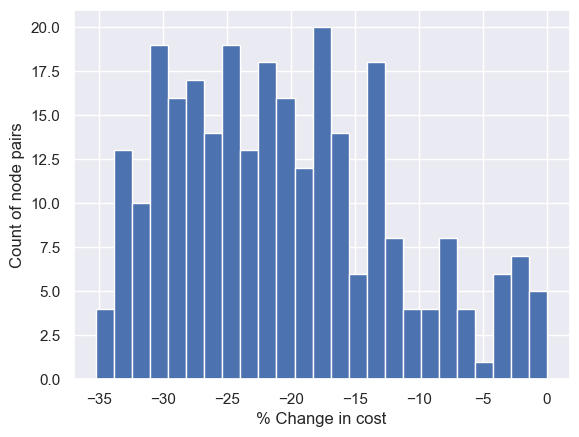

In [13]:
import seaborn as sns
sns.set_theme()

fig = ((station_cost_df.cost-  no_bike_cost)*100/no_bike_cost).hist(bins=25)

fig.set_xlabel("% Change in cost")
fig.set_ylabel("Count of node pairs")

In [41]:
# compute degree centrality for all nodes
out_degree_centrality = nx.out_degree_centrality(siouxFalls.graph)
in_degree_centrality = nx.in_degree_centrality(siouxFalls.graph)

# compute betweenness centrality for all nodes
betweenness_centrality = nx.betweenness_centrality(siouxFalls.graph)

# compute eigenvector centrality for all nodes
eigenvector_centrality = nx.eigenvector_centrality(siouxFalls.graph)

# closeness_centrality
closeness_centrality = nx.closeness_centrality(siouxFalls.graph)


In [63]:
centrality = pd.DataFrame([betweenness_centrality, out_degree_centrality, in_degree_centrality, eigenvector_centrality, closeness_centrality]).T.rename(columns={0:'betweenness',1:'out_degree', 2:'in_degree', 3:'eigenvector', 4:'closeness'})

In [43]:
station1 = []
station2 = []
for station in station_cost_df.stations:
    station1.append(station[0])
    station2.append(station[1])

station_cost_df['station1'] = station1
station_cost_df['station2'] = station2

In [64]:
station_cost_df.merge(centrality, how='left', left_on='station1', right_index=True)

,stations,cost,station1,station2,betweenness,out_degree,in_degree,eigenvector,closeness
0,"(2, 5)",4.172028e+06,2,5,0.036797,0.086957,0.086957,0.041609,0.267442
1,"(4, 23)",3.907821e+06,4,23,0.100838,0.130435,0.130435,0.128455,0.348485
2,"(11, 20)",3.489095e+06,11,20,0.226379,0.173913,0.173913,0.239538,0.403509
3,"(15, 20)",3.375514e+06,15,20,0.122476,0.173913,0.173913,0.317121,0.370968
4,"(13, 23)",3.283128e+06,13,23,0.060277,0.086957,0.086957,0.066920,0.306667
...,...,...,...,...,...,...,...,...,...
271,"(9, 14)",3.470960e+06,9,14,0.075878,0.130435,0.130435,0.208734,0.365079
272,"(24, 19)",3.351849e+06,24,19,0.070422,0.130435,0.130435,0.122064,0.302632
273,"(6, 16)",3.296530e+06,6,16,0.097666,0.130435,0.130435,0.110150,0.310811
274,"(2, 14)",3.187483e+06,2,14,0.036797,0.086957,0.086957,0.041609,0.267442


In [65]:
station_cost_centrality = station_cost_df.merge(centrality, how='left', left_on='station1', right_index=True).merge(centrality, how='left', left_on='station2', right_index=True,  suffixes=("_o", "_d"))
station_cost_centrality['int_in_degree_centrality'] = station_cost_centrality.in_degree_o * station_cost_centrality.in_degree_d
station_cost_centrality['int_out_degree_centrality'] = station_cost_centrality.out_degree_o * station_cost_centrality.out_degree_d

In [66]:
station_cost_centrality['pct_change']  = (station_cost_centrality.cost - no_bike_cost)/no_bike_cost

In [46]:
def sum_edge_volumes(n, graph):
    volume_sum = 0
    for neighbor in graph.neighbors(n):
        volume_sum += graph[n][neighbor]['object'].vol
    return volume_sum

In [47]:
import networkx as nx

def calculate_hypothetical_travel_time_reduction(hyp_edge, graph, traffic_dict):
    # Copy the original graph
    new_graph = graph.copy()

    # Add the hypothetical edge to the new graph
    shortest_path = nx.shortest_path(graph, hyp_edge[0], hyp_edge[1], weight='time')
    edge_time = 0
    for i in range(len(shortest_path) - 1):
        edge_time += new_graph[shortest_path[i]][shortest_path[i+1]]['time']
    new_graph.add_edge(hyp_edge[0], hyp_edge[1], time=edge_time*.5)

    # Calculate the original travel time
    orig_travel_time = 0
    for origin, dest in traffic_dict.keys():
        volume = traffic_dict[(origin, dest)]
        shortest_path = nx.shortest_path(graph, origin, dest, weight='time')
        edge_time = 0
        for i in range(len(shortest_path) - 1):
            edge_time += graph[shortest_path[i]][shortest_path[i+1]]['time']
        orig_travel_time += edge_time * volume

    # Calculate the hypothetical travel time
    hyp_travel_time = 0
    for origin, dest in traffic_dict.keys():
        volume = traffic_dict[(origin, dest)]
        shortest_path = nx.shortest_path(new_graph, origin, dest, weight='time')
        edge_time = 0
        for i in range(len(shortest_path) - 1):
            edge_time += new_graph[shortest_path[i]][shortest_path[i+1]]['time']
        hyp_travel_time += edge_time * volume

    # Calculate the travel time reduction
    travel_time_reduction = orig_travel_time - hyp_travel_time

    return travel_time_reduction


In [67]:
station_cost_centrality['volume_x'] = station_cost_centrality.station1.apply(sum_edge_volumes, graph=siouxFalls.graph)
station_cost_centrality['volume_y'] = station_cost_centrality.station2.apply(sum_edge_volumes, graph=siouxFalls.graph)
station_cost_centrality['hyp_time_reduction'] = station_cost_centrality.stations.apply( calculate_hypothetical_travel_time_reduction, graph= siouxFalls.graph, traffic_dict= siouxFalls.od_vols)

In [68]:
station_cost_centrality['log_hyp_time_reduction'] = np.log((station_cost_centrality.hyp_time_reduction / np.linalg.norm(station_cost_centrality.hyp_time_reduction)))

In [69]:
station_cost_centrality['shortest_path_length'] = station_cost_centrality.apply(lambda x: nx.shortest_path_length(siouxFalls.graph, x.station1, x.station2, weight='time'), axis=1)

In [70]:
station_cost_centrality.columns

Index(['stations', 'cost', 'station1', 'station2', 'betweenness_o',
       'out_degree_o', 'in_degree_o', 'eigenvector_o', 'closeness_o',
       'betweenness_d', 'out_degree_d', 'in_degree_d', 'eigenvector_d',
       'closeness_d', 'int_in_degree_centrality', 'int_out_degree_centrality',
       'pct_change', 'volume_x', 'volume_y', 'hyp_time_reduction',
       'log_hyp_time_reduction', 'shortest_path_length'],
      dtype='object')

In [73]:
station_cost_centrality.columns = ['stations', 'cost', 'station1', 'station2', 'betweenness_1',
       'out_degree_1', 'degree_1', 'eigenvector_1', 'closeness_1',
       'betweenness_2', 'degree_2', 'in_degree_2', 'eigenvector_2',
       'closeness_2', 'int_degree_centrality', 'int_out_degree_centrality',
       'pct_change', 'volume_1', 'volume_2', 'hyp_time_reduction',
       'log_hyp_time_reduction', 'shortest_path_length']

In [74]:
import statsmodels.api as sm
X_df = station_cost_centrality[['betweenness_1','betweenness_2', 
       'degree_1', 'degree_2', 
       'eigenvector_1', 'eigenvector_2', 
        'closeness_1','closeness_2', 
        'int_degree_centrality',
       'volume_1', 'volume_2', 
       'shortest_path_length']]
y = station_cost_centrality[['pct_change']]

In [75]:
# now you can scale the data using any of the available methods, such as StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X_df), columns=X_df.columns)

scaled_df = sm.add_constant(scaled_df)


In [76]:
big_model = sm.OLS(station_cost_centrality['pct_change'], scaled_df).fit()
latex_model = big_model.summary().as_latex()
print(latex_model)

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}          &   pct\_change    & \textbf{  R-squared:         } &     0.071   \\
\textbf{Model:}                  &       OLS        & \textbf{  Adj. R-squared:    } &     0.029   \\
\textbf{Method:}                 &  Least Squares   & \textbf{  F-statistic:       } &     1.683   \\
\textbf{Date:}                   & Tue, 04 Apr 2023 & \textbf{  Prob (F-statistic):} &   0.0705    \\
\textbf{Time:}                   &     20:20:27     & \textbf{  Log-Likelihood:    } &    298.91   \\
\textbf{No. Observations:}       &         276      & \textbf{  AIC:               } &    -571.8   \\
\textbf{Df Residuals:}           &         263      & \textbf{  BIC:               } &    -524.7   \\
\textbf{Df Model:}               &          12      & \textbf{                     } &             \\
\textbf{Covariance Type:}        &    nonrobust     & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tab

#### Comparison between the lowest and highest costs.

In [37]:
# low 4- lowest costs
low_4 = np.argsort(station_cost_centrality.cost)[0:4].values
# top 4 - 4 highest costs
top_4 = np.argsort(station_cost_centrality.cost)[-4:]

In [38]:
station_cost_centrality.to_csv('station_cost_centrality.csv')

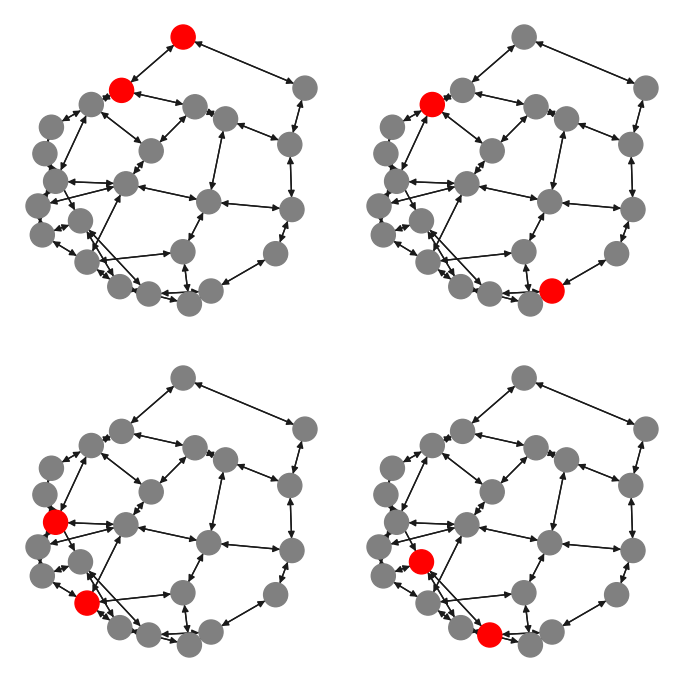

In [39]:
import matplotlib.pyplot as plt
import networkx as nx

# create four color sets
node_colors1 = ['red' if node in station_cost_centrality.loc[low_4].iloc[0].stations else 'gray' for node in siouxFalls.graph.nodes()]
node_colors2 = ['red' if node in station_cost_centrality.loc[low_4].iloc[1].stations else 'gray' for node in siouxFalls.graph.nodes()]
node_colors3 = ['red' if node in station_cost_centrality.loc[low_4].iloc[2].stations else 'gray' for node in siouxFalls.graph.nodes()]
node_colors4 = ['red' if node in station_cost_centrality.loc[low_4].iloc[3].stations else 'gray' for node in siouxFalls.graph.nodes()]
# create a 2x2 plot grid
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
pos = nx.kamada_kawai_layout(siouxFalls.graph, weight='time')


# plot each graph in a different subplot
nx.draw(siouxFalls.graph.copy(), ax=axs[0, 0], pos=pos, node_color=node_colors1)
nx.draw(siouxFalls.graph.copy(), ax=axs[0, 1],pos=pos, node_color=node_colors2)
nx.draw(siouxFalls.graph.copy(), ax=axs[1, 0],pos=pos, node_color=node_colors3)
nx.draw(siouxFalls.graph.copy(), ax=axs[1, 1],pos=pos, node_color=node_colors4)

# these are the 4 lowest costs
# set plot title and axis labels
plt.tight_layout()
plt.show()

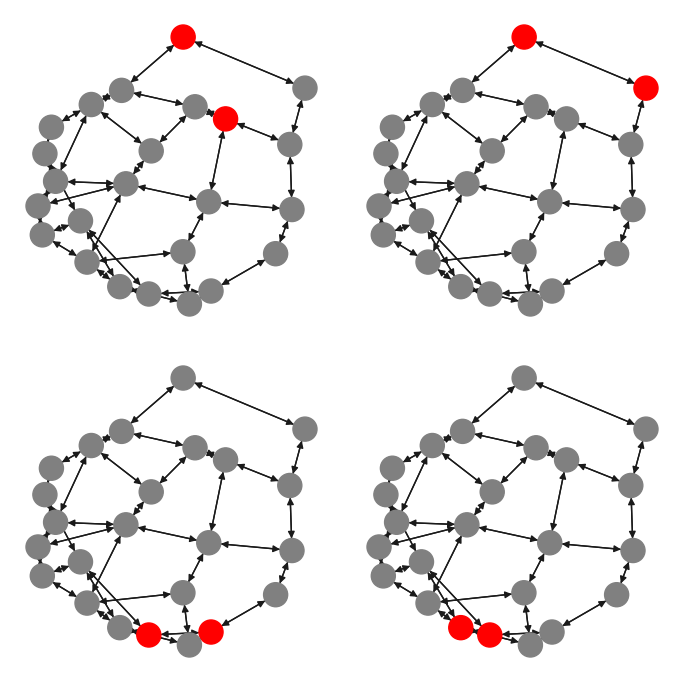

In [35]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.pyplot import figure

# create four color sets
node_colors1 = ['red' if node in station_cost_centrality.loc[top_4].iloc[0].stations else 'gray' for node in siouxFalls.graph.nodes()]
node_colors2 = ['red' if node in station_cost_centrality.loc[top_4].iloc[1].stations else 'gray' for node in siouxFalls.graph.nodes()]
node_colors3 = ['red' if node in station_cost_centrality.loc[top_4].iloc[2].stations else 'gray' for node in siouxFalls.graph.nodes()]
node_colors4 = ['red' if node in station_cost_centrality.loc[top_4].iloc[3].stations else 'gray' for node in siouxFalls.graph.nodes()]
# create a 2x2 plot grid
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
pos = nx.kamada_kawai_layout(siouxFalls.graph, weight='time')


# plot each graph in a different subplot
nx.draw(siouxFalls.graph.copy(), ax=axs[0, 0], pos=pos, node_color=node_colors1)
nx.draw(siouxFalls.graph.copy(), ax=axs[0, 1],pos=pos, node_color=node_colors2)
nx.draw(siouxFalls.graph.copy(), ax=axs[1, 0],pos=pos, node_color=node_colors3)
nx.draw(siouxFalls.graph.copy(), ax=axs[1, 1],pos=pos, node_color=node_colors4)

# set plot title and axis labels

# these are the four highest costs
plt.tight_layout()
plt.show()

When we actually plot path length and cost, the relationship is weaker.

Text(0.5, 0, 'Closeness_2')

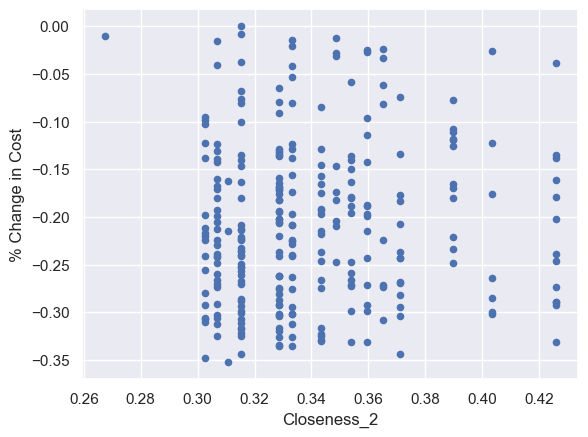

In [83]:
fig = station_cost_centrality.plot.scatter(y='pct_change', x='closeness_2')
fig.set_ylabel('% Change in Cost')
fig.set_xlabel('Closeness_2')

In [152]:
centrality_dict = station_cost_centrality[['station1','closeness_x', 'betweenness_x', 'degree_x']].set_index('station1').to_dict(orient='dict')

In [153]:
def get_topsis(closeness_centr,between_centr,degr_centr):
    centralities=dict()
    for i in zip(closeness_centr,closeness_centr.values(),between_centr.values(),degr_centr.values()):
        centralities[i[0]]=i[1],i[2],i[3]
    centrdf=pd.DataFrame.from_dict(centralities)
    centrdf=centrdf.T
    centrdf.columns=['cc','bc','dc']    
    wv=np.array([0.1180,0.2689,0.6131])
    wv=wv.reshape(-1,1)
    centrmatrix=centrdf.copy().to_numpy()
    centrmatrix[:,0]=(centrmatrix[:,0]*wv[0])/(np.sqrt(np.sum(np.square(centrmatrix[:,0]))))
    centrmatrix[:,1]=(centrmatrix[:,1]*wv[1])/(np.sqrt(np.sum(np.square(centrmatrix[:,1]))))
    centrmatrix[:,2]=(centrmatrix[:,2]*wv[2])/(np.sqrt(np.sum(np.square(centrmatrix[:,2]))))
    nis=np.array([centrmatrix[:,0].min(),centrmatrix[:,1].min(),centrmatrix[:,2].min()])
    pis=np.array([centrmatrix[:,0].max(),centrmatrix[:,1].max(),centrmatrix[:,2].max()])
    centrdf['s+']=np.sum(np.square(centrmatrix-pis),axis=1)
    centrdf['s-']=np.sum(np.square(centrmatrix-nis),axis=1)
    # np.sum(np.square(centrmatrix-pis),axis=1)/(np.sum(np.square(centrmatrix-pis),axis=1)+np.sum(np.square(centrmatrix-nis),axis=1))
    centrdf['topsis']=np.sum(np.square(centrmatrix-pis),axis=1)/(np.sum(np.square(centrmatrix-pis),axis=1)+np.sum(np.square(centrmatrix-nis),axis=1))
    return centrdf

In [157]:
topsis = get_topsis(centrality_dict['closeness_x'], centrality_dict['betweenness_x'], centrality_dict['degree_x']).sort_values(by='topsis', ascending=False)
station_cost_topsis = station_cost_centrality.merge(topsis[['topsis']], how='left', left_on='station1', right_index=True).merge(topsis[['topsis']], how='left', left_on='station2', right_index=True)

In [209]:
station_cost_centrality.to_csv('station_cost_centrality_capacity.csv')

In [35]:
lowest_costs = pd.Series(stations2).iloc[top_4]

station_graph_tuples = [(station, siouxFalls) for station in stations2]

import multiprocessing as mp

# Step 3: Define the number of processes to use
num_processes = mp.cpu_count()

# Step 4: Create a multiprocessing pool object with the desired number of processes
pool = mp.Pool(num_processes)

# Step 5: Map the function to the input data using the multiprocessing pool
all_costs = pool.starmap(compute_eq_cost, station_graph_tuples)

# Step 6: Close the pool to free up resources
pool.close()